<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/tutorials/Radiation-pulse-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/tutorials/Radiation-pulse-analysis.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>


‼️ **Prerequisites** ‼️:
- Access to the `Nucleonics` Google drive folder (it must also be added as a shortcut called "Nucleonics" in your own drive)
- Access to the nucleonics `.env` folder (where sensitive info lives)

# Radiation pulse analysis

The analysis notebook relies on the "Nuclear particle master" sheet to provide timestamps for different phases of an experiment in order to perform bin-independent radiation analysis.

The aim is to develop techniques to characterise the background and detect anomalies in a way that minimises numerical artifiacts.


## Running this notebook

Go ahead and change the `experiment_id` and `channel_number` below and then run the whole notebook.

You will be asked a couple of time to authenticate with your Google account, but after that all the analysis will happen automatically.

In [1]:
experiment_id = 1
channel_number = 0

## Libraries

In [2]:
# Auth
import sys, os
import shutil
from google.colab import drive
from google.colab import auth
from google.auth import default

# Interacting with sheets
import gspread

# Data analysis
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sqlalchemy import create_engine, text
from scipy.stats import kstest


#Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from IPython.display import HTML

from plotly.offline import init_notebook_mode
import plotly.io as pio

# Initialize offline mode for notebooks
# init_notebook_mode(connected=True)

pio.renderers.default = "notebook_connected+colab"

## Authentication

We need to do a few authentication steps:
- Bring in the database credentials from Google drive so that we can pull data from the live database.
- Bring in the nuclear particle master sheet ID.
-  Authenticate Colab to pull the nuclear particle master sheet using the Drive API.

In [3]:
# Mount Drive
drive.mount('/content/drive')

# Copy SQL credentials from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/psql_credentials.py", "psql_credentials.py")

# Copy sheet ID file from Google drive
shutil.copy("/content/drive/MyDrive/Nucleonics/.env/sheet_ids.py", "sheet_ids.py");

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Import SQL credentials
from psql_credentials import PGUSER, PGPASSWORD, PGHOST, PGPORT, PGDATABASE

# Import sheet ID for the nuclear particle master sheet
from sheet_ids import NUCLEAR_PARTICLE_MASTER as sheet_id

# Create the database connection string
connection_uri = f'postgresql+psycopg2://{PGUSER}:{PGPASSWORD}@{PGHOST}:{PGPORT}/{PGDATABASE}'
engine = create_engine(connection_uri)

In [5]:
# Authenticate using Colab's built-in credentials
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

## Extracting experimental timestamps

We need to
- Open the master sheet
- Find the row corresponding with the experiment
- Extract the timestamp columns

Because the master sheet is organised in blocks that share an experiment ID (to avoid visual overload) we'll need to "fill in" the experiment ID for all rows once the sheet is brought into a pandas dataframe.

In [6]:
# Fill experiment IDs based on the block organisation of the master sheet
def fill_experiment_id(df):
    experiment_id = None
    updated_ids = []

    for index, row in df.iterrows():
        if pd.notna(row['Experiment ID']) and row['Experiment ID'] != '':
            experiment_id = row['Experiment ID']
        updated_ids.append(experiment_id)

    df['Experiment ID'] = updated_ids
    return df

In [7]:
sheet = gc.open_by_key(sheet_id).sheet1

# Read the sheet into a pandas DataFrame
df = pd.DataFrame(sheet.get_all_records())

# Fill the experiment IDs based on the block organisation of the master sheet
df = fill_experiment_id(df)

In [8]:
# Find the rows where Experiment ID matches
rows = df[df['Experiment ID'] == experiment_id]

if len(rows) == 0:
  raise ValueError(f"No matser sheet entry for 'Experiment ID' = {experiment_id}")

# Exract digitizer for SQL table identification
digitizer = rows.iloc[0]["Digitizer"]

# Extract times
times = rows.iloc[[0]][['Setup', 'Calibration', 'Background 1', 'Experiment', 'Background 2', 'End']]
times = times.apply(pd.to_datetime)

# Extract the row corresponding to the specified channel number
row = rows[rows["Digitizer channel number"] == channel_number]

if len(row) == 0:
  raise ValueError(f"No matser sheet entry for 'Experiment ID' = {experiment_id}, 'Digitizer channel number' = {channel_number}")

# Extract the psp neutron/gamma discriminator
psp = row["psp threshold"].iloc[0]

# Display the extracted times
times.head()

Setup         Calibration        Background 1 Experiment  \
0 2024-12-14 00:01:00 2024-12-17 19:48:00 2024-12-18 12:01:00        NaT   

  Background 2                 End  
0          NaT 2025-01-23 23:59:00

## Pulling the radiation events

We store each individual radiation pulse in our database. These pulses are characterised by an energy and a psp value. The radiation pulses contain a mixture of gamma and neutron events which can be distinguised through PSD analysis at different levels of sophistication.

The [simplest PSD analysis](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/PSD_Analysis.ipynb) is to use a constant PSP discriminator value above which the pulses are considered to be neutrons, below are gammas. We can also combine this with an similar energy discriminator.

We can then query the database to pull only the events that match our PSD analysis requirements.

In [9]:
def get_event_data(start_time, end_time, psp=">0", energy=">0"):
  query = f"""
  SELECT * FROM {digitizer}_ch{channel_number}
  WHERE channels[1] {psp} AND channels[2] {energy}
  AND time BETWEEN '{start_time}' AND '{end_time}'
  ORDER BY time;
  """
  df = pd.read_sql(query, engine, index_col=None)
  df.set_index('time', inplace=True)
  return df

We can now get all the event data for the different periods in the experiement.

In [10]:
def get_all_event_data(times, psp=">0", energy=">0"):
  event_data = {}
  event_periods = {}
  columns = times.columns  # Include all columns, including 'Setup'

  for i in range(len(columns) - 1):  # Stop before the last column
      start_time = times.iloc[0, i]
      if pd.notna(start_time):
          # Find the next non-empty time
          end_time = None
          for j in range(i + 1, len(columns)):
              if pd.notna(times.iloc[0, j]):
                  end_time = times.iloc[0, j]
                  break
          # Only proceed if a valid end_time was found
          if end_time is not None:
              data = get_event_data(start_time, end_time, psp, energy)
              event_data[columns[i]] = data
              event_periods[columns[i]] = end_time - start_time

  return event_data, event_periods

## Neutron background analysis

We're going to look at the neutron events during the background phase of the experiment and perform an analysis to characterise the background. Often, analysis of this kind is performed by "binning" the data and looking at counts per second/minute/hour. While it is often more intuitive to view the radiation rates, in our analysis we will take a bin-indepedent view by analysing the time in between neutron events. This way, we avoid any artifacts of binning.

We can extract only the neutron events by using the psp values stored in the master spreadsheet.

In [11]:
psp

0.20703125

In [12]:
neutron_data, neutron_periods = get_all_event_data(times, f">{psp}")

### Reconstructing the pulses

Let's see what the pulse data looks like for the background.

In [13]:
neutron_data["Background 1"].head()

channels            ps  \
time                                                                     
2024-12-18 12:01:06.548699   [0.2903225806451613, 124.0]  548699378967   
2024-12-18 12:01:33.072547   [0.23529411764705882, 85.0]   72547435760   
2024-12-18 12:01:35.257360  [0.21153846153846154, 104.0]  257360458374   
2024-12-18 12:01:53.526694   [0.3089430894308943, 123.0]  526694059371   
2024-12-18 12:02:19.055839   [0.2897196261682243, 107.0]   55838584899   

                                 id  
time                                 
2024-12-18 12:01:06.548699  1565759  
2024-12-18 12:01:33.072547  1566211  
2024-12-18 12:01:35.257360  1566245  
2024-12-18 12:01:53.526694  1566590  
2024-12-18 12:02:19.055839  1567104

The `channels` column gives `[psp, energy]`.

The database timestamp is limited in precision to microseconds, so we store the full picosecond precision in the `ps` columm. We therefore need to combine the time in microseconds with the picosecond time piece. It turns out that pandas only does datetime to nanoseconds so we'll have to discard some precision.

In [14]:
def reconstruct_ns_pulses(df):
  # Floor the index to strip microseconds
  df.index = df.index.floor('s')

  # Convert picoseconds to nanoseconds
  df['ps_ns'] = df['ps'] // 1_000  # convert ps → ns

  # Create high-resolution timestamp
  df['timestamp'] = df.index + pd.to_timedelta(df['ps_ns'], unit='ns')

  # Set timestamp as index
  df.set_index('timestamp', inplace=True)

  # Create 'counts' column with value 1 for each row
  df['counts'] = 1

  # Drop all unneeded columns (including 'channels')
  df.drop(columns=['id', 'ps', 'ps_ns', 'channels'], inplace=True)

  # Sort by timestamp index
  df.sort_index(inplace=True)

  return df

We'll now reconstruct the nanosecond pulses for all the experimental periods.

In [15]:
for key, value in neutron_data.items():
  neutron_data[key] = reconstruct_ns_pulses(value)

### Inter-pulse distribution

During the background phase of the experiment, we expect to measure radiation pulses randomly over time - following a Poisson distribution. This distribution can be studied by looking at count rates - as we do in the [Eljen Detector Background Characterization](https://github.com/project-ida/arpa-e-experiments/blob/main/tutorials/Eljen-Background-Characterization.ipynb) notebook. Here, we will study the distribution by instead looking at the times between individual events.

For a Poisson process occuring at an average rate of $\lambda$, the probability that the time between events $\Delta t$ is less than some time $t$ is given by:

$$
P_{\rm Poisson}(\Delta t \le t) = 1 - e^{-\lambda t}
$$

We can estimate the $\lambda$ from the experimentally derived average inter-pulse time $\overline{\Delta t}$ via:

$$
\lambda = \frac{1}{\overline{\Delta t}}
$$

In [16]:
background = neutron_data["Background 1"]

In [17]:
deltas = np.diff(background.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
delta_sorted = np.sort(deltas)

In [18]:
# Estimate lambda (rate in events per second)
lam = 1 / np.mean(delta_sorted)

# Calculate the theoretical distribution
P_poisson = 1 - np.exp(-lam * delta_sorted)

We've now got the theoretical inter-pulse distribution based on the assumption that the system indeed behaves like a Poisson process. How does the system really behave?

We need to calculate the cumulative distribution of events in order to compare with the Poisson probability distribution.

$$
P_{\rm exp}(\Delta t \le t) = \frac{1}{N} \sum_{i=1}^{N} \mathbf{1}\bigl(\Delta t_i \le t\bigr)
$$

In [19]:
P_exp = np.arange(1, len(delta_sorted) + 1) / len(delta_sorted)

Let's see how the Poisson distribution compares to the experimental one.

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(delta_sorted, P_exp, label="Empirical")
plt.plot(delta_sorted, P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {lam:.2f}/s)")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t )")
plt.title("Cumulative inter-pulse time probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Visually, the level of agreement is superb. We can be more quantitative using a [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test), but we'll save this analysis for later in the notebook when we look at how to test for anomalies.

It's instructive to look at the cumulative pulses alongside the counts per minute.

In [21]:
background_cpm = background.resample("60s").size().rename("counts").to_frame()
fig = go.Figure(layout=dict(yaxis_title="Counts per min", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Counts per min", x=background_cpm.index, y=background_cpm.counts))
# fig.show()



## Anomaly detection

We can use the inter-pulse cumulative probability to detect deviations from normal background, aka anomalies. To demonstrate this, we'll combine the background period with a calibration period (where we had a californium neutron source present).

Support for third party widgets will remain active for the duration of the session. To disable support:

In [22]:
neutron_periods["Calibration"]

Timedelta('0 days 16:13:00')

In [23]:
neutron_periods["Background 1"]

Timedelta('36 days 11:58:00')

Let's see what a 16 hour "blast" of neutrons does to 36 days worth of background. We'll plot the new cumulative distribution of events alongside the others.

In [24]:
neutrons_with_source =  neutron_data["Calibration"] + neutron_data["Background 1"]

In [25]:
deltas_with_source = np.diff(neutrons_with_source.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
delta_sorted_with_source = np.sort(deltas_with_source)
cdf_with_source = np.arange(1, len(delta_sorted_with_source) + 1) / len(delta_sorted_with_source)

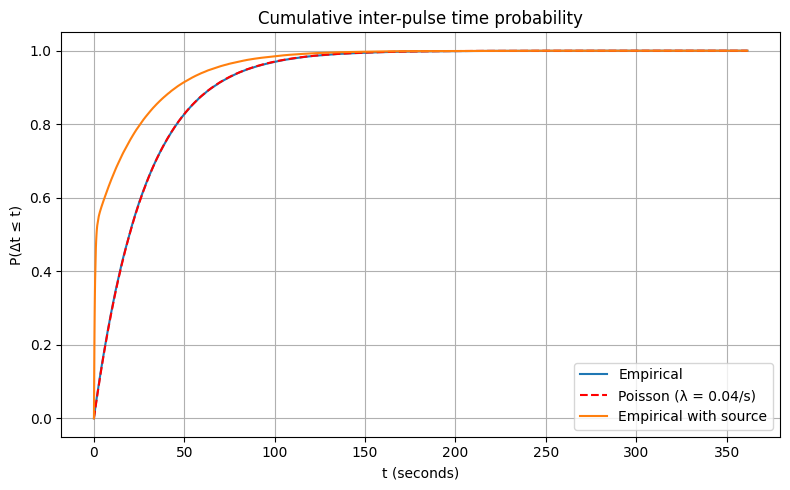

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(delta_sorted, P_exp, label="Empirical")
plt.plot(delta_sorted, P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {lam:.2f}/s)")
plt.plot(delta_sorted_with_source, cdf_with_source, label="Empirical with source")

plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t)")
plt.title("Cumulative inter-pulse time probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can clearly see the difference between what's expected from a normal background and a strong neutron source.

The reason for the inital jump in the empirical plot with a source is that the source lowers the time between events because there are more events per second. The longer the source is present, the higher the fraction of events that occur within a small time of one another.

Let's again look at the counts per minute associated with this plot.

In [27]:
neutrons_with_source_cpm = neutrons_with_source.resample("60s").size().rename("counts").to_frame()
fig = go.Figure(layout=dict(yaxis_title="Counts per min", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Counts per min", x=neutrons_with_source_cpm.index, y=neutrons_with_source_cpm.counts))

### Synthetic anomalies

Although statistical analysis is the most robust way of determining anomalies, it's important to consider how easy it is to visually discern changes in the distribution because we often lean on visuals in an initial analysis.

For this exercise, we'll simulate the appearance of random short bursts of neutrons and look at the changes to the inter-pulse cumulative distribution.

We'll create a function that allows us to inject a number of poisson distributed bursts of a given duration and strength into an experimetnal period. We'll define the strength through a multiplier which scales the average rate from the given experimental period.

In [28]:
def inject_poisson_bursts(df, n_bursts=3, burst_duration_s=1.0, burst_multiplier=10, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Step 1: Compute background rate
    deltas = np.diff(df.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
    lambda_bg = 1 / np.mean(deltas)

    # Step 2: Pick burst start times uniformly in range
    start_time = df.index.min()
    end_time = df.index.max() - pd.Timedelta(seconds=burst_duration_s)
    burst_starts = pd.to_datetime(
        np.random.uniform(start_time.value, end_time.value, n_bursts).astype("int64")
    )

    all_burst_timestamps = []

    for t0 in burst_starts:
        t0 = pd.Timestamp(t0)
        t1 = t0 + pd.Timedelta(seconds=burst_duration_s)
        lambda_burst = lambda_bg * burst_multiplier
        expected_count = np.random.poisson(lam=lambda_burst * burst_duration_s)

        # Generate inter-pulse times
        inter_arrivals = np.random.exponential(1 / lambda_burst, expected_count)
        event_times = t0 + pd.to_timedelta(np.cumsum(inter_arrivals), unit="s")
        event_times = event_times[event_times <= t1]

        all_burst_timestamps.extend(event_times)

    # Step 3: Create burst DataFrame
    burst_df = pd.DataFrame(index=pd.to_datetime(all_burst_timestamps))
    burst_df["counts"] = 1

    # Step 4: Combine with original
    combined = pd.concat([df, burst_df])
    combined.sort_index(inplace=True)

    return combined

Let's create 5 bursts, with a strength 20 times that of the background and let's make them last for 10 mins each.

In [29]:
neutrons_synthetic = inject_poisson_bursts(background,n_bursts=5, burst_duration_s=600, burst_multiplier=20)

We'll first look at the counts per minute associated with the this synthetic pulse data:

In [30]:
neutrons_synthetic_cpm = neutrons_synthetic.resample("60s").size().rename("counts").to_frame()
fig = go.Figure(layout=dict(yaxis_title="Counts per min", showlegend=False, height=600, width=800))
fig.add_trace(go.Scattergl(name="Counts per min", x=neutrons_synthetic_cpm.index, y=neutrons_synthetic_cpm.counts))

Although the synthetic pulses look obviously anomalous in this case, we still want to be able to go through the process of measuring just how anomalous the pulses are.

Let's now perform the inter-pulse analysis on this synthetic data.

In [31]:
synthetic_deltas = np.diff(neutrons_synthetic.index.values).astype("timedelta64[ns]") / np.timedelta64(1, "s")
synthetic_deltas_sorted = np.sort(synthetic_deltas)
cdf_with_synthetic_neutrons = np.arange(1, len(synthetic_deltas_sorted) + 1) / len(synthetic_deltas_sorted)

Instead of plotting just the cumulative probabilities, we're now going to add some statistical information so that we can be more quantitative.

We're going to plot a confidence band around the theoretical Poisson distribution based on [Kolmogorov-Smirnov analysis](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

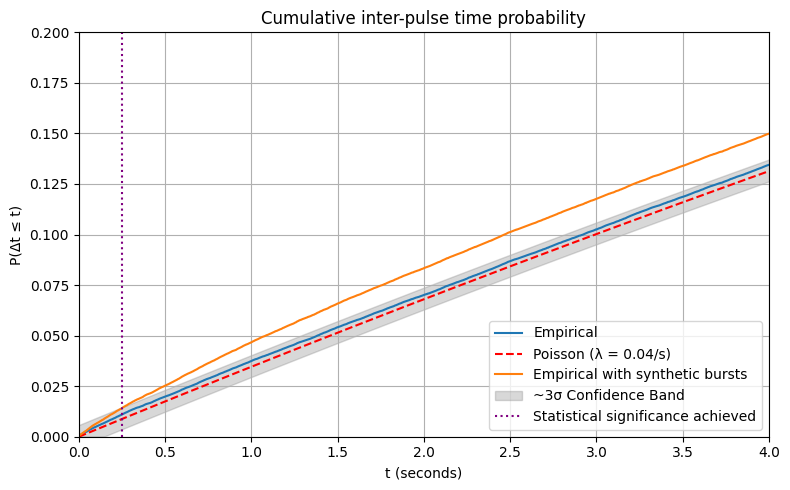

In [32]:
# Number of samples (n)
n = len(delta_sorted)

# Desired confidence level (e.g. ~3σ = 99.7%)
alpha = 0.003

# Kolmogorov–Smirnov critical value for given alpha and n
D_alpha = np.sqrt(-0.5 * np.log(alpha / 2) / n)


# Upper and lower bounds of the confidence band
upper_bound = np.clip(P_poisson + D_alpha, 0, 1)
lower_bound = np.clip(P_poisson - D_alpha, 0, 1)

plt.figure(figsize=(8, 5))
plt.plot(delta_sorted, P_exp, label="Empirical")
plt.plot(delta_sorted, P_poisson, linestyle="--", color="red", label=f"Poisson (λ = {lam:.2f}/s)")
plt.plot(synthetic_deltas_sorted, cdf_with_synthetic_neutrons, label="Empirical with synthetic bursts")
plt.fill_between(delta_sorted, lower_bound, upper_bound, color='gray', alpha=0.3, label="~3σ Confidence Band", zorder=1)

# Recompute bounds for synthetic burst dataset
n_synth = len(synthetic_deltas_sorted)
D_alpha_synth = np.sqrt(-0.5 * np.log(alpha / 2) / n_synth)
P_poisson_synth = 1 - np.exp(-lam * synthetic_deltas_sorted)
upper_bound_synth = np.clip(P_poisson_synth + D_alpha_synth, 0, 1)
lower_bound_synth = np.clip(P_poisson_synth - D_alpha_synth, 0, 1)

first_cross_index = np.argmax(
    (cdf_with_synthetic_neutrons > upper_bound_synth) |
    (cdf_with_synthetic_neutrons < lower_bound_synth)
)

plt.axvline(synthetic_deltas_sorted[first_cross_index], color='purple', linestyle=':', label="Statistical significance achieved")


plt.xlabel("t (seconds)")
plt.ylabel("P(Δt ≤ t)")
plt.xlim([0,4])
plt.ylim([0,0.2])
plt.title("Cumulative inter-pulse time probability")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In the plot above, we see that the "Empirical with synthetic bursts" (orange) is  significantly different (determined by the grey region) to the theoretical Poisson distribution (red). We chose a $3\sigma$ threshold which means that there is less than 0.3% chance that the deviation happened due to chance.

We can also see that without the synthetic bursts, the Empirical (blue) is not significantly different from the theoretical Poisson distribution (red). This is of course what one would expect from random background events.

While it is helpful to get a visual sense of how the cumulative inter-pulse probabilities differ from a theoretical Poisson, it's also helpful to get a number that tells us what is the probability that our data happened by chance. We have seen it's less than 0.3%, but what is the exact number?

For this we can perform a [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test).

In [33]:
# Run KS test against an exponential distribution with estimated lambda
ks_stat, p_value = kstest(synthetic_deltas_sorted, 'expon', args=(0, 1/lam))

print(f"There is probability of {p_value} that our synthetic pulses happened by chance.")

There is probability of 1.3570168520896394e-34 that our synthetic pulses happened by chance.
